## 1 Instruction of running the code
### 1.1 Important libraries & Version control
Google Colab:
Python 3.7.13
Sklearn 1.0.2
Tensorflow/Keras 2.80
### 1.2 Running environment
The python code is tested and running under the environment of both anaconda and google colab. The computational power of the CPU would decide how long the code will run and be aware the dataset is pulled from the internet so make sure your device has a connection to it. The process time may vary from different versions of google colab such that the pro version would assign more memory/cpu/gpu. The local environment is anaconda 4.12.0 under Windows 11 with CPU of i7-117800H and 16G RAM.
### 1.3 Directory of tuning result
It is highly recommended that before you start tuning hyperparameters in the LSTM model, put a directory to your own location in the tuner definition. This provides a safe location and avoids authentication problems if you are running anaconda without administrator mode that blocks you from creating a file folder in a relative directory automatically. Moreover, reproduction of tuning results can be covered by the file stored as well. 
### 1.4 How to successfully run the code
It is recommended to run ipynb by running from top to bottom through each code block. For an ease of running best model only, you may want to skip the hyperparameters tuning section just to avoid the massive processing time.


### 1.5 Helpful command to install and upgrade packages

In [ ]:
!pip install xgboost
!pip install yfinance
!pip install -q -U keras-tuner
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

### 1.6 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import xgboost as xgb
# For reading stock data
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
# For time stamps
from datetime import datetime
# For data pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# LSTM
import math
import keras_tuner
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import save_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import optimizers,datasets

### 4.7 Set the maximum number of rows and columns can be viewed 

In [ ]:
pd.set_option('display.max_rows', None)  # Set the maximum number of rows that can be viewed
pd.set_option('display.max_columns', None)  # Set the maximum number of columns that can be viewed

## 2 Data Preprocessing

### 2.1 Download the latest five-year data to 08/05/2022

In [ ]:
# Pull stock price of APPLE in 5 years 
end = datetime(2022, 5, 8)
start = datetime(end.year - 5, end.month, end.day)
# using DataReader to read the stock price from start point to end point
df = yf.download('AAPL', start=start, end=end)
df = df.reset_index(level=0)
print(df.head())
print(df.info())

[*********************100%***********************]  1 of 1 completed
        Date       Open       High        Low      Close  Adj Close     Volume
0 2017-05-08  37.257500  38.424999  37.257500  38.252499  36.063488  195009600
1 2017-05-09  38.467499  38.720001  38.362499  38.497501  36.294476  156521600
2 2017-05-10  38.407501  38.485001  38.027500  38.314999  36.122414  103222800
3 2017-05-11  38.112499  38.517502  38.077499  38.487499  36.434814  109020400
4 2017-05-12  38.674999  39.105000  38.667500  39.025002  36.943645  130108000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 n

In [ ]:
df.shape

(1260, 7)

### 2.2 Generate extra features to analyze data

We want to know the year, month, day, week of the year, and day of the week corresponding to Date, try to find the correlations between time characteristics and closing prices

In [ ]:
#Generate the year, month, day, week of the year, and day of the week corresponding to Date
df["Date"] = pd.to_datetime(df["Date"])
df["DayOfYear"] = df["Date"].dt.dayofyear
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["weekday"] = df["Date"].dt.weekday
df["week"] = df["Date"].dt.week

# Adjust the position of columns
df = df[['Date', 'High', 'Low', 'Open', 'Volume', 'DayOfYear', 'day',
         'month', 'year', 'weekday', 'week', 'Close']]
# View all columns
print(df.columns)

print(df.head())

# View shape of df
print(df.shape)

Index(['Date', 'High', 'Low', 'Open', 'Volume', 'DayOfYear', 'day', 'month',
       'year', 'weekday', 'week', 'Close'],
      dtype='object')
        Date       High        Low       Open     Volume  DayOfYear  day  \
0 2017-05-08  38.424999  37.257500  37.257500  195009600        128    8   
1 2017-05-09  38.720001  38.362499  38.467499  156521600        129    9   
2 2017-05-10  38.485001  38.027500  38.407501  103222800        130   10   
3 2017-05-11  38.517502  38.077499  38.112499  109020400        131   11   
4 2017-05-12  39.105000  38.667500  38.674999  130108000        132   12   

   month  year  weekday  week      Close  
0      5  2017        0    19  38.252499  
1      5  2017        1    19  38.497501  
2      5  2017        2    19  38.314999  
3      5  2017        3    19  38.487499  
4      5  2017        4    19  39.025002  
(1260, 12)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


### 2.3 The function of generate plots to analyse data

We plot the close price and different time features to visualize the relationships, using the feature generated above

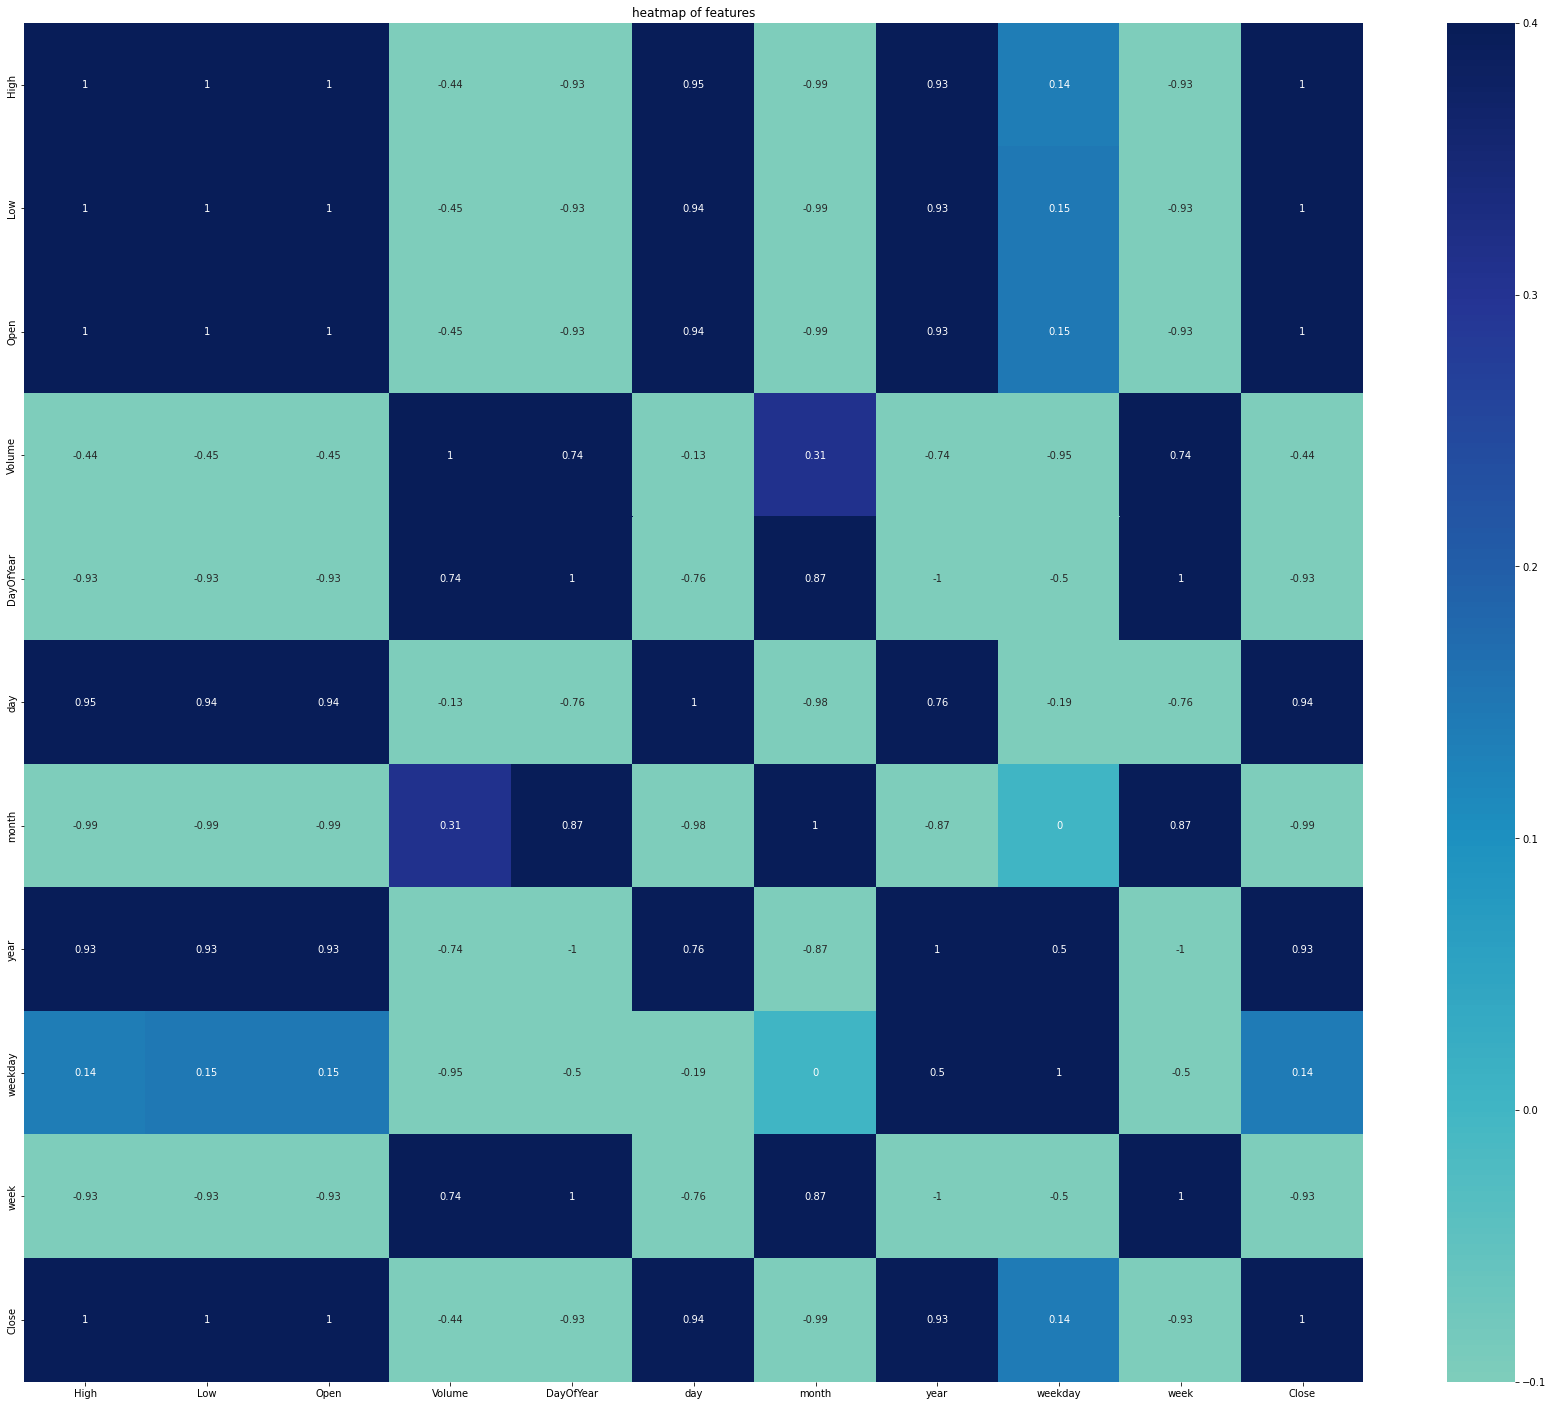

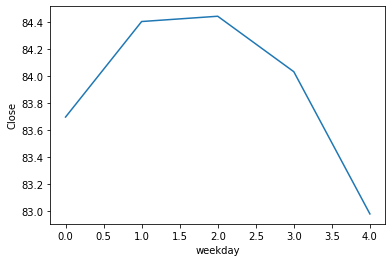

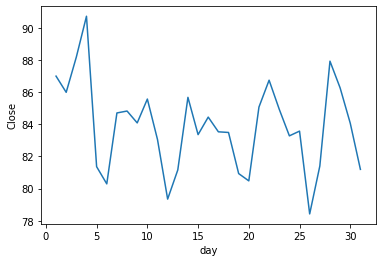

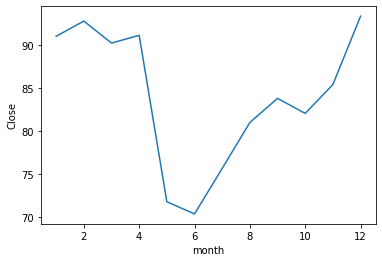

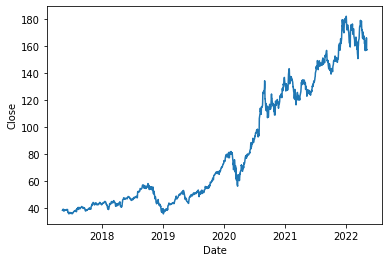

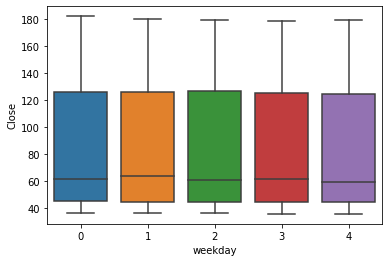

In [ ]:
# generate plots
def generatePlot(train_data):
    plt.subplots(figsize=(30, 25))
    plt.title("heatmap of features")
    sns.heatmap(train_data[::500].corr(), cmap="YlGnBu", annot=True, vmin=-0.1, vmax=0.4, center=0)
    plt.show()

    close_weekday = train_data.groupby("weekday", as_index=False)["Close"].mean()
    sns.lineplot(data=close_weekday, x="weekday", y="Close")
    plt.show()

    close_day = train_data.groupby("day", as_index=False)["Close"].mean()
    sns.lineplot(data=close_day, x="day", y="Close")
    plt.show()

    close_month = train_data.groupby("month", as_index=False)["Close"].mean()
    sns.lineplot(data=close_month, x="month", y="Close")
    plt.show()

    sns.lineplot(data=train_data, x="Date", y="Close" )
    plt.show()

    sns.boxplot(data=train_data, x="weekday", y="Close")
    plt.show()
generatePlot(df)

In [ ]:
# delete "Date" feature
df.drop(["Date"], axis=1, inplace=True)

### 2.4 Pre-process the numeric data of stocks

We choose Min-MaxScaler function to normalize the numeric data, instead of time features

In [ ]:
# definite the preprocessing function, choosing "High", "Low", "Open", "Volume", "Close" features
def preprocessing(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    transformed_data = scaler.fit_transform(df[["High", "Low", "Open", "Volume", "Close"]])

    df["High"] = transformed_data[:, 0]
    df["Low"] = transformed_data[:, 1]
    df["Open"] = transformed_data[:, 2]
    df["Volume"] = transformed_data[:, 3]

    scaler_close = MinMaxScaler(feature_range=(0, 1))
    transformed_close = scaler_close.fit_transform(df[["Close"]])

    df["Close"] = transformed_close
    return scaler, scaler_close


scaler, scaler_close = preprocessing(df)

data_np = df.values

### 2.5 Adding features because using time series-based LSTM model

Since we use a time series-based LSTM model for prediction, we add the first 60 days of each day as new features to each row of the dataset, so the shape of the dataset is reduced by 60 rows, conversely adding relative columns.

In [ ]:
# Use the close price of the past_days days as a feature
data = []
past_days = 60

for i in range(60, df.shape[0]):
    # Concatenate the i-th row of data_np
    # Put the close price of the previous past_days days as a feature and put it into the feature of the i-th day
    data.append(np.hstack((data_np[i - past_days:i, -1], data_np[i])).tolist())

data = np.array(data)
print(data.shape)

(1200, 71)


### 2.6 Divide training set and test set

We choose 80% of dataset to become training set and 20% to become test set

In [ ]:
split = 0.8
# Use sklearn method to divide training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=1 - split, random_state=32)

## 3 SVM model

35.41506061852441


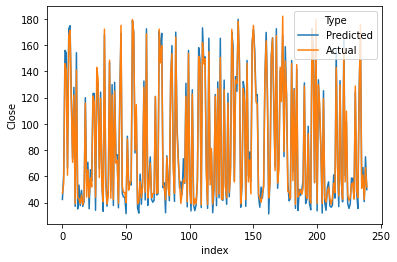

In [ ]:
# train the svm regression model
svm_regressor = SVR(kernel="linear", C=0.1, gamma='scale')
svm_regressor.fit(X_train, y_train)
y_hat = svm_regressor.predict(X_test)
y_test_inver = scaler_close.inverse_transform([y_test])
y_hat_inver = scaler_close.inverse_transform([y_hat])
# computing mse
mse = np.mean((y_test_inver - y_hat_inver) ** 2)
print('best mse:', mse)

#plot a plot figure to show the difference between predicted and actual labels
a = pd.DataFrame({'Close': y_hat_inver[0,:], 'Type': 'Predicted'})
a = a.append(pd.DataFrame({'Close': y_test_inver[0,:], 'Type': 'Actual'}))
a = a.reset_index()
sns.lineplot(data=a, x="index", y="Close", hue="Type")
plt.show()

### 3.1 Use grid search to find the best parameter of SVM model

In [ ]:
param_grid = {'kernel': ['rbf','linear','sigmoid'],
              'C': [0.1, 1, 100, 200, 1000],
              'gamma': ['scale', 'auto']}
print("Parameter grid:\n{}".format(param_grid))
grid_search = GridSearchCV(SVR(), param_grid, cv=5,
                           return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {}".format(grid_search.best_score_))
print("Best estimator: {}".format(grid_search.best_estimator_))

Parameter grid:
{'kernel': ['linear'], 'C': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 1, 10, 100], 'gamma': ['scale', 'auto']}
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9827585584168658
Best estimator: SVR(C=0.1, kernel='linear')


## 4 RandomForest model

1.3757713016979776


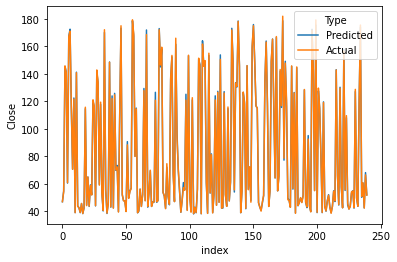

In [ ]:
model_random_forest = RandomForestRegressor(n_estimators =70, max_depth = 7, random_state=32)
#  train the random forest regression model
model_random_forest.fit(X_train, y_train)
y_hat = model_random_forest.predict(X_test)
y_test_inver = scaler_close.inverse_transform([y_test])
y_hat_inver = scaler_close.inverse_transform([y_hat])

# computing mse
mse = np.mean((y_test_inver - y_hat_inver) ** 2)
print('best mse:',mse)

#plot a plot figure to show the difference between predicted and actual labels
a = pd.DataFrame({'Close': y_hat_inver[0, :], 'Type': 'Predicted'})
a = a.append(pd.DataFrame({'Close': y_test_inver[0, :], 'Type': 'Actual'}))
a = a.reset_index()

sns.lineplot(data=a, x="index", y="Close", hue="Type")
plt.show()

### 4.1 Use grid search to find the best parameter

In [ ]:
param_grid = {'n_estimators': [35, 40, 50, 60, 70], 'max_depth': [5, 6, 7, 12]}
print("Parameter grid:\n{}".format(param_grid))
grid_search = GridSearchCV(RandomForestRegressor(random_state=32), param_grid, cv=5,
                           return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'n_estimators': [120, 125, 130, 135], 'max_depth': [7, 8, 9, 10, 11]}
Best parameters: {'max_depth': 8, 'n_estimators': 125}
Best cross-validation score: 0.9993962292237443
Best estimator:
RandomForestRegressor(max_depth=8, n_estimators=125)


### 4.2 Train XGboostmodel to predict data

Start training xgboost model...
[0]	train-rmse:0.294886	valid-rmse:0.309891
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:0.277376	valid-rmse:0.291462
[2]	train-rmse:0.260928	valid-rmse:0.274159
[3]	train-rmse:0.245445	valid-rmse:0.257831
[4]	train-rmse:0.230905	valid-rmse:0.242504
[5]	train-rmse:0.217245	valid-rmse:0.228155
[6]	train-rmse:0.20439	valid-rmse:0.214644
[7]	train-rmse:0.192265	valid-rmse:0.201898
[8]	train-rmse:0.180898	valid-rmse:0.189883
[9]	train-rmse:0.170213	valid-rmse:0.178665
[10]	train-rmse:0.160123	valid-rmse:0.168083
[11]	train-rmse:0.150667	valid-rmse:0.158215
[12]	train-rmse:0.14175	valid-rmse:0.148844
[13]	train-rmse:0.133379	valid-rmse:0.140053
[14]	train-rmse:0.125476	valid-rmse:0.131789
[15]	train-rmse:0.118051	valid-rmse:0.123997
[16]	train-rmse:0.111067	valid-rmse:0.11673
[17]	train-rmse:0.104498	valid-rmse:0.109858
[18]	train-rmse:0.098368	

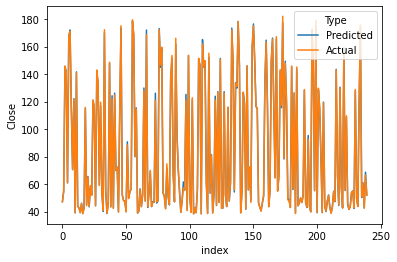

In [ ]:
def xgboost(x_train_v, y_train_v, x_valid, y_valid):
    print("Start training xgboost model...")
    y_train_v = np.log(1 + y_train_v)
    y_valid = np.log(1 + y_valid)
    train_matrix = xgb.DMatrix(x_train_v, y_train_v)
    valid_matrix = xgb.DMatrix(x_valid, y_valid)

    param = {'max_depth':4,
             'eta': 0.06,
             'gamma': 0.0001,
             'subsample': 0.75,
             'colsample_bytree': 0.6,
             'objective': 'reg:squarederror', }
    params = list(param.items())
    num_boost_round = 10000
    evals = [(train_matrix, 'train'), (valid_matrix, 'valid')]
    reg = xgb.train(params, train_matrix, num_boost_round, evals,
                    verbose_eval=1, early_stopping_rounds=100)

    y_valid_hat = reg.predict(valid_matrix)
    y_valid_hat = (np.exp(y_valid_hat) - 1)

    y_test_inver = scaler_close.inverse_transform([y_test])
    y_hat_inver = scaler_close.inverse_transform([y_valid_hat])
    # 计算mse
    mse = np.mean((y_test_inver - y_hat_inver) ** 2)
    print(mse)
    a = pd.DataFrame({'Close': y_hat_inver[0, :], 'Type': 'Predicted'})
    a = a.append(pd.DataFrame({'Close': y_test_inver[0, :], 'Type': 'Actual'}))
    a = a.reset_index()

    sns.lineplot(data=a, x="index", y="Close", hue="Type")
    plt.show()


xgboost(X_train, y_train, X_test, y_test)
